## Customer Behaviour Insight Enginge - Behaviour Funnels (Notebook 3)

This notebook uses the feature-engineered tables from previous steps to build multi-step behaviour funnels.

**Goals of this notebook:**

- Load the enriched session and customer tables from `data/processed/`
- Build an overall multi-step funnel:
    - Page View -> Add to Cart -> Checkout -> Purchase
- Compute conversion rates between each step
- Prepare the logic to extend funnels by:
    - device (mobile/ tablet/ desktop)
    - country
    - product-level funnels (later)

In [ ]:
import pandas as pd 
import numpy as np 

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120) 


In [11]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# 1. Load processed / feature tables 

processed_path = "../data/processed/"

sessions_enriched = pd.read_csv(
    processed_path + "sessions_enriched.csv",
    parse_dates=["start_time", "session_start", "session_end"]
)

customers_analytics = pd.read_csv(
    processed_path + "customers_analytics.csv",
    parse_dates=["signup_date", "first_order_date", "last_order_date"]
)

events = pd.read_csv(
    processed_path + "events_clean.csv",
    parse_dates=["timestamp"]
)

print("sessions_enriched:", sessions_enriched.shape)
print("customers_analytics:", customers_analytics.shape)
print("events:", events.shape)

sessions_enriched.head()

sessions_enriched: (120000, 17)
customers_analytics: (20000, 17)
events: (760958, 10)


,session_id,customer_id,start_time,device,source,country,session_start,session_end,session_duration_min,n_events,n_page_views,n_add_to_cart,n_checkout,n_purchase,total_qty,session_revenue,made_purchase
0,1,12360,2021-12-27 00:01:36,mobile,email,DE,2021-12-27 00:08:36,2021-12-27 01:59:36,111.0,10,7,3,0,0,3.0,0.00,0
1,2,13917,2025-01-31 21:29:42,desktop,organic,PL,2025-01-31 21:48:42,2025-01-31 23:07:42,79.0,8,5,1,1,1,1.0,85.72,1
2,3,1022,2024-02-19 00:52:50,tablet,organic,FR,2024-02-19 00:57:50,2024-02-19 01:17:50,20.0,5,2,1,1,1,1.0,116.17,1
3,4,2882,2024-08-04 19:54:31,mobile,direct,GB,2024-08-04 20:24:31,2024-08-04 20:47:31,23.0,2,2,0,0,0,0.0,0.00,0
4,5,1286,2022-06-28 13:58:08,desktop,email,ES,2022-06-28 14:19:08,2022-06-28 15:27:08,68.0,6,6,0,0,0,0.0,0.00,0


In [ ]:
sessions_enriched.columns

Index(['session_id', 'customer_id', 'start_time', 'device', 'source', 'country', 'session_start', 'session_end',
       'session_duration_min', 'n_events', 'n_page_views', 'n_add_to_cart', 'n_checkout', 'n_purchase', 'total_qty',
       'session_revenue', 'made_purchase'],
      dtype='object')

## Build funnel flags per session 

For each session, we want to know whether it reached each step of the funnel: 

1. Page view (`has_view`)
2. Add to cart (`has_cart`)
3. Checkout (`has_checkout`)
4. Purchaes (`has_purchase`)

Using counts such as `n_page_views` it's now possible to convert to simple boolean flags per session. 

In [14]:
# 2. Build funnel flags per session 

sessions_enriched["has_view"] = sessions_enriched["n_page_views"] > 0
sessions_enriched["has_cart"] = sessions_enriched["n_add_to_cart"] > 0
sessions_enriched["has_checkout"] = sessions_enriched["n_checkout"] > 0
sessions_enriched["has_purchase"] = sessions_enriched["n_purchase"] > 0

sessions_enriched[[
    "session_id", 
    "device",
    "source",
    "has_view",
    "has_cart",
    "has_checkout",
    "has_purchase"
]].head()

,session_id,device,source,has_view,has_cart,has_checkout,has_purchase
0,1,mobile,email,True,True,False,False
1,2,desktop,organic,True,True,True,True
2,3,tablet,organic,True,True,True,True
3,4,mobile,direct,True,False,False,False
4,5,desktop,email,True,False,False,False


## 3. Overall funnel performance 

Summarise how sessions flow through teh funnel: 

- How many sessions reach each step?
- What percentage of all sessions do that? 
- What percentages of sessions move from one step to the next? 

In [25]:
# 3. Overall funnel performance 

total_sessions = len(sessions_enriched)

# Count how many sessions reached each step
n_view = sessions_enriched["has_view"].sum()
n_cart = sessions_enriched["has_cart"].sum()
n_checkout = sessions_enriched["has_checkout"].sum()
n_purchase = sessions_enriched["has_purchase"].sum()

print("Total sessions:", total_sessions)
print("Reached page view:  ", n_view)
print("Reached add to card:", n_cart)
print("Reached checkout:   ", n_checkout)

# Conversion vs ALL sessions 

view_rate_all = n_view / total_sessions
cart_rate_all = n_cart / total_sessions
checkout_rate_all = n_checkout / total_sessions
purchase_rate_all = n_purchase / total_sessions

print("\Conversions vs ALL sessions:")
print(f"  Any page view: {view_rate_all:.2%}")
print(f"  Any add to cart:  {cart_rate_all:.2%}")
print(f"  Any checkout:  {checkout_rate_all:.2%}")
print(f"  Any purchase:   {purchase_rate_all:.2%}")

# Stage-to-stage conversion
# Only look at sessions that reached the prevevious step 
view_to_cart = sessions_enriched.loc[sessions_enriched["has_view"], "has_cart"].mean()
cart_to_checkout = sessions_enriched.loc[sessions_enriched["has_cart"], "has_checkout"].mean()
checkout_to_purchase = sessions_enriched.loc[sessions_enriched["has_checkout"], "has_purchase"].mean()

print("\nStage-to-stage conversion:")
print(f". View -> Cart:  {view_to_cart:.2%}")
print(f". Cart -> Checkout:   {cart_to_checkout:.2%}")
print(f"  Checkout -> PUrchase:  {checkout_to_purchase:.2%}")

Total sessions: 120000
Reached page view:   120000
Reached add to card: 81518
Reached checkout:    44909
\Conversions vs ALL sessions:
  Any page view: 100.00%
  Any add to cart:  67.93%
  Any checkout:  37.42%
  Any purchase:   27.98%

Stage-to-stage conversion:
. View -> Cart:  67.93%
. Cart -> Checkout:   55.09%
  Checkout -> PUrchase:  74.77%


## 4. Funnel breakdown by device 

Compare funnel performance across devices: 

- How many sessions per device?
- What fraction of sessions on each device reach:
    - page view
    - cart
    - checkout 
    - purchase 


In [26]:
# 4. Funnel breakdown by device 

funnel_by_device = (
    sessions_enriched
    .groupby("device")
    .agg(
        n_sessions=("session_id", "nunique"),
        view_rate=("has_view", "mean"),
        cart_rate=("has_cart", "mean"),
        checkout_rate=("has_checkout", "mean"), 
        purchase_rate=("has_purchase", "mean")
                    
    )
    .reset_index()
)

# Make percentages easier to read
funnel_by_device[["view_rate", "cart_rate", "checkout_rate", "purchase_rate"]] = (
    funnel_by_device[["view_rate", "cart_rate", "checkout_rate", "purchase_rate"]] * 100
).round(1)

funnel_by_device

,device,n_sessions,view_rate,cart_rate,checkout_rate,purchase_rate
0,desktop,45547,100.0,68.0,37.5,28.0
1,mobile,65942,100.0,67.9,37.4,28.0
2,tablet,8511,100.0,67.3,37.0,27.7


## 5. Funnel breakdown by country

Repeat the same idea for countries to see:

- Which markets have better conversion?
- Where do customers drops off more often? 



In [27]:
# 5. Funnel breakdown by country 

funnel_by_country = (
    sessions_enriched
    .groupby("country")
    .agg(
        n_sessions=("session_id", "nunique"),
        view_rate=("has_view", "mean"),
        cart_rate=("has_cart", "mean"),
        checkout_rate=("has_checkout", "mean"),
        purchase_rate=("has_purchase", "mean")
        
    )
    .reset_index()
)

funnel_by_country[["view_rate", "cart_rate", "checkout_rate", "purchase_rate"]]= (
    funnel_by_country[["view_rate", "cart_rate", "checkout_rate", "purchase_rate"]] * 100
).round(1)

funnel_by_country.sort_values("purchase_rate", ascending=False).head(10)

,country,n_sessions,view_rate,cart_rate,checkout_rate,purchase_rate
14,SG,4780,100.0,67.9,38.0,28.8
2,BR,8573,100.0,68.1,38.3,28.7
16,ZA,2349,100.0,68.0,37.8,28.3
9,JP,5841,100.0,68.1,37.6,28.3
11,NL,5261,100.0,68.3,37.4,28.3
7,GB,9451,100.0,67.8,37.4,28.1
15,US,21913,100.0,67.8,37.4,28.0
6,FR,7811,100.0,68.0,37.4,28.0
4,DE,8332,100.0,68.2,37.4,27.9
5,ES,5580,100.0,68.5,37.4,27.9


## 6. Visualize the overall funnel 

To quickly see drop-off between steps, plot the number of sessions that reach each stage of the funnel: 
- Page view
- Add to card
- Checkout
- Purchase 

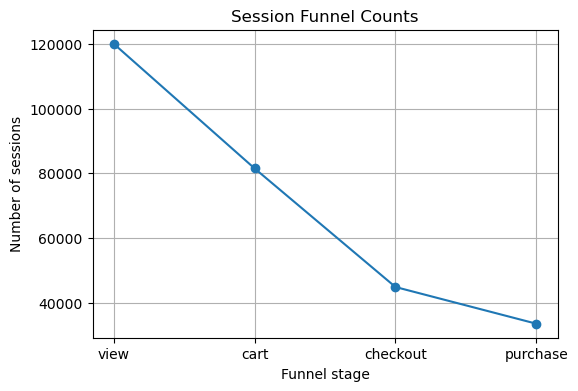

In [28]:
import matplotlib.pyplot as plt

#Reuse countrs from earlier (or recompute quickly)
funnel_counts= {
    "view": n_view,
    "cart": n_cart, 
    "checkout": n_checkout,
    "purchase": n_purchase,
}

stages = list(funnel_counts.keys())
values = list(funnel_counts.values())

plt.figure(figsize=(6,4))
plt.plot(stages, values, marker="o")
plt.title("Session Funnel Counts")
plt.xlabel("Funnel stage")
plt.ylabel("Number of sessions")
plt.grid(True)
plt.show()